In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: marcodia
"""
import numpy as np
import random
import xarray as xr
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
import tensorflow as tf

import import_ipynb
import sys
import os 

import network_arch as network
import metrics
import plot
import settings 

2023-05-12 08:49:46.337893: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


importing Jupyter notebook from network_arch.ipynb
importing Jupyter notebook from metrics.ipynb
importing Jupyter notebook from plot.ipynb
importing Jupyter notebook from settings.ipynb


In [2]:
#%% >>>>> ADDITIONAL FUNCTIONS >>>>>
def is_ndjf(month):
    return np.logical_or(month<=2, month>=11)

def is_ndjfm(month):
    return np.logical_or(month<=3, month>=11)

# MAKE THE NN ARCHITECTURE
def make_model():
    # Define and train the model
    tf.keras.backend.clear_session()
    model = network.defineNN(HIDDENS,
                             input1_shape = X_train.shape[1],
                             output_shape=NLABEL,
                             ridge_penalty1=RIDGE1,
                             dropout=DROPOUT,
                             act_fun='relu',
                             network_seed=NETWORK_SEED)
    
    loss_function = tf.keras.losses.CategoricalCrossentropy()    
    model.compile(
                  optimizer = tf.keras.optimizers.Adam(learning_rate=LR_INIT),
                  loss = loss_function,
                  metrics = [
                      tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None),
                      metrics.PredictionAccuracy(NLABEL)
                      ]
                  )           
    return model, loss_function

#---------------------------------------------------
#LEARNING RATE CALLBACK FUNCTION
def scheduler(epoch, lr):
    # This function keeps the initial learning rate for the first ten epochs
    # and decreases it exponentially after that.
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [5]:
EXPERIMENT = EXPERIMENT NAME #need to name from settings file

Xdata_folder = X_DATA #data folder with x-data
Ydata_folder = Y_DATA #data folder with y-data

ddir_X = DIRECTORY_X
ddir_Y = DIRECTORY_Y
ddir_out = DIRECTORY_OUT 
params = settings.get_settings(EXPERIMENT)

PREDICTOR_VAR  = params['PREDICTOR_VAR']           
PREDICTAND_VAR = params['PREDICTAND_VAR']              
REGION_TOR     = params['REGION_TOR']          
REGION_TAND    = params['REGION_TAND']            
training_ens   = params['training_ens']            
validation_ens = params['validation_ens']           
testing_ens    = params['testing_ens']           
train_list     = params['train_list']           
lead           = params['lead']            
days_average   = params['days_average']            
GLOBAL_SEED    = params['GLOBAL_SEED']            
HIDDENS        = params['HIDDENS']          
DROPOUT        = params['DROPOUT']            
RIDGE1         = params['RIDGE1']                    
LR_INIT        = params['LR_INIT']
BATCH_SIZE     = params['BATCH_SIZE']           
RANDOM_SEED    = params['RANDOM_SEED']            
act_fun        = params['act_fun']            
N_EPOCHS       = params['N_EPOCHS']           
PATIENCE       = params['PATIENCE']   


In [6]:
#>>>>>SET UP <<<<<<<<<<<<<<<
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.compat.v1.random.set_random_seed(GLOBAL_SEED)

NLABEL = 2

YEARS = '1850-1949'
STRT = pd.to_datetime('11-01-1850')
END   = pd.to_datetime('2-28-1949')  + dt.timedelta(days=1)

time_range = xr.cftime_range(str(STRT)[:10], str(END)[:10],calendar = 'noleap') #[0:10] corresponds to full datestamp
time_range_ndjf = time_range.where(is_ndjf(time_range.month)).dropna()
TIME_X = xr.DataArray(time_range_ndjf + dt.timedelta(days=0), dims=['time'])     
TIME_Y = xr.DataArray(time_range_ndjf + dt.timedelta(days=lead+days_average), dims=['time'])  #below comment explains time segmentation

    #Based on the 14-day running average, Dec 6 1850 corresponds to the prior 14days averaged together. 
    #So a Nov 1 1850 prediction is for 21 days later of the 3-4week future average

# ----- X TRAINING ------
X_finame = PREDICTOR_VAR+'_'+REGION_TOR+'_'+YEARS+'_'+'ens'+train_list+'_dailyanom_detrend.nc'
X_all_full = xr.open_dataarray(ddir_X+X_finame)
X_all = X_all_full.where(X_all_full.time == TIME_X, drop=True)

Xtrain = X_all.stack(time_all=('ens','time')) # lat,lon,time*8 (8= number of training ens members) 
Xtrain = Xtrain.transpose('time_all','lat','lon') # time*8,lat,lon

Xtrain_std = np.std(Xtrain,axis=0)
Xtrain_mean = np.mean(Xtrain,axis=0)
Xtrain = (Xtrain-Xtrain_mean)/Xtrain_std
X_train = Xtrain.stack(z=('lat','lon'))

# ---------- X VALIDATION----------
X_finame  = PREDICTOR_VAR+'_'+REGION_TOR+'_'+YEARS+'_'+'ens'+str(validation_ens)+'_dailyanom_detrend.nc'
Xval = xr.open_dataarray(ddir_X+X_finame)

Xval= Xval.where(Xval.time == TIME_X, drop=True)
Xval = (Xval - Xtrain_mean)/Xtrain_std

#%% ----- Y TRAINING--------

Ytrain_finame = PREDICTAND_VAR+'_'+REGION_TAND+'_boxavg_'+YEARS+'_'+'ens'+train_list+'_dailyanom_detrend_14dayavg.nc'
Y_all = xr.open_dataarray(ddir_Y+Ytrain_finame)
Y_all= Y_all.where(Y_all.time == TIME_Y, drop=True)

# ----- Standardize Y training -----
Ytrain = Y_all[:,:]    #already box averaged so no lat or lon dimension 
Ytrain = Ytrain.stack(time_all=('ens','time')) # time*8 (Ytrain time is actually 365*100-(13*8) because of 14-day average)
Ytrain_med = np.median(Ytrain)
Ytrain = Ytrain - Ytrain_med       #Subtracting the median forces the output above or below zero 

# ----- Y VALIDATION --------
Yval_finame = PREDICTAND_VAR+'_'+REGION_TAND+'_boxavg_'+YEARS+'_'+'ens'+str(validation_ens)+'_dailyanom_detrend_14dayavg.nc'
Yval_all  = xr.open_dataarray(ddir_Y+Yval_finame)
Yval_all= Yval_all.where(Yval_all.time == TIME_Y, drop=True)

# ----- Standardize Y validation -----
Yval = Yval_all[:]
Yval = Yval - Ytrain_med         


# ----- Make binary -----
# training
Ytrain[np.where(Ytrain>=0)[0]] = 1
Ytrain[np.where(Ytrain<0)[0]]  = 0
# validation
Yval[np.where(Yval>=0)[0]] = 1
Yval[np.where(Yval<0)[0]]  = 0

# make Yval have equal 0s and 1s so that random chance is 50%
n_valzero = np.shape(np.where(Yval==0)[0])[0]
n_valone  = np.shape(np.where(Yval==1)[0])[0]
i_valzero = np.where(Yval==0)[0]
i_valone  = np.where(Yval==1)[0]

if n_valone > n_valzero:
    isubset_valone = np.random.choice(i_valone,size=n_valzero,replace=False)
    i_valnew = np.sort(np.append(i_valzero,isubset_valone))
    Yval = Yval.isel(time=i_valnew,drop=True)
    X_val  = Xval[i_valnew].stack(z=('lat','lon'))
elif n_valone < n_valzero:
    isubset_valzero = np.random.choice(i_valzero,size=n_valone,replace=False)
    i_valnew = np.sort(np.append(isubset_valzero,i_valone))
    Yval = Yval.isel(time=i_valnew,drop=True)
    X_val  = Xval[i_valnew].stack(z=('lat','lon'))
else:
    X_val = Xval.stack(z=('lat','lon'))

# ----- Make one hot vector -----
enc = preprocessing.OneHotEncoder()
onehotlabels      = enc.fit_transform(np.array(Ytrain).reshape(-1, 1)).toarray()
onehotlabels_val  = enc.fit_transform(np.array(Yval).reshape(-1, 1)).toarray()

FileNotFoundError: [Errno 2] No such file or directory: b'/Users/marcodia/Research/Data/processed_fields/exp_1/exp_100/PRECT_tropfullband_1850-1949_ens01234567_dailyanom_detrend.nc'

In [5]:
#output_class = (X_train == 1).astype(int) + (X_train == 0).astype(int)
output_class_train = np.array(Ytrain)
output_train = (output_class_train.reshape(-1,1) == np.unique(output_class_train)).astype(int)
calcpercent = lambda cat: str((np.sum(output_class_train == cat)/len(output_class_train)*100).astype(int))
# Print out the sizes of each class- should be 50/50 

print('Frequency for each Category')
print('Below Zero: ' + calcpercent(0) + '%')
print('Above Zero: ' + calcpercent(1) + '%')

Frequency for each Category
Below Zero: 50%
Above Zero: 50%


In [6]:
#output_class = (X_train == 1).astype(int) + (X_train == 0).astype(int)
output_class_val = np.array(Yval)
output_val = (output_class_val.reshape(-1,1) == np.unique(output_class_val)).astype(int)
calcpercent = lambda cat: str((np.sum(output_class_val == cat)/len(output_class_val)*100).astype(int))
# Print out the sizes of each class
print('Frequency for each Category')
print('Below Zero: ' + calcpercent(0) + '%')
print('Above Zero: ' + calcpercent(1) + '%')

Frequency for each Category
Below Zero: 50%
Above Zero: 50%


210
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3168)]            0         
                                                                 
 dense (Dense)               (None, 128)               405632    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 409,826
Trainable params: 409,826
Non-trainable params: 0
_________________________________________________________________


2023-03-14 21:30:36.648392: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 220.
Epoch 245: early stopping
Elapsed time during fit = 6050.99 seconds



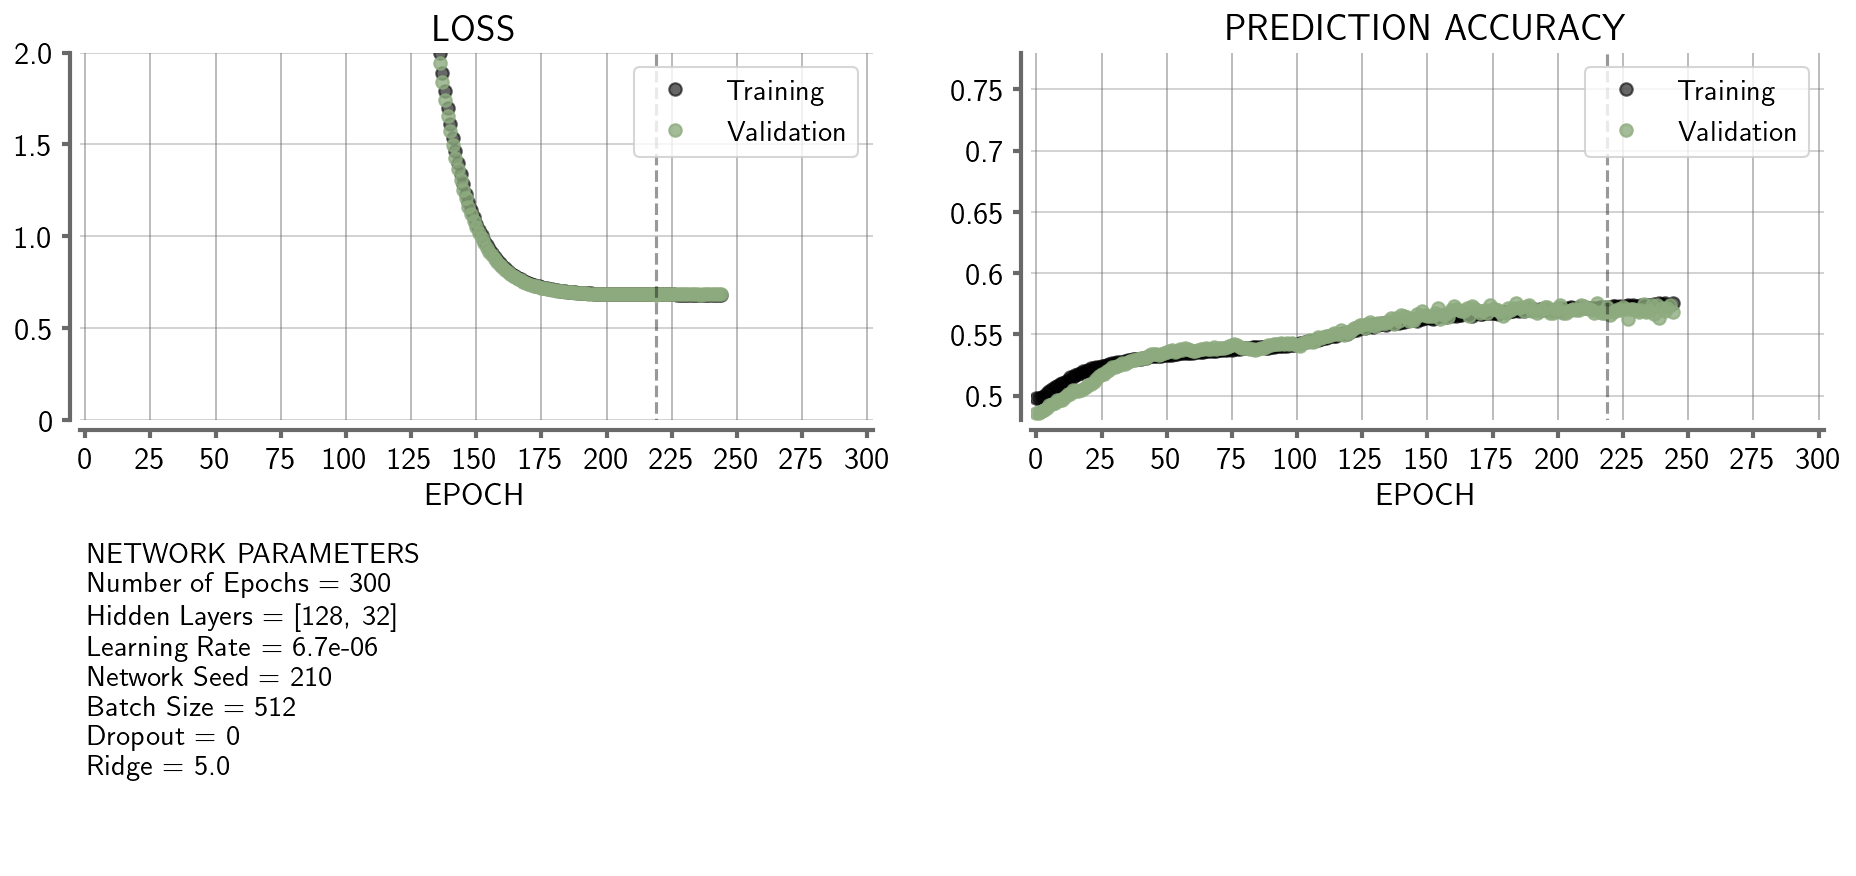

2970/2970 [==============================] - 11s 4ms/step
Zero prediction accuracy: 56%
Zero: 52.% of predictions
One prediction accuracy: 57%
One: 47.% of predictions
Validation Loss at Best Epoch: 0.6825003027915955
47
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3168)]            0         
                                                                 
 dense (Dense)               (None, 128)               405632    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 409,826
Trainable params: 409,826
Non-trainable params: 0
________________________________

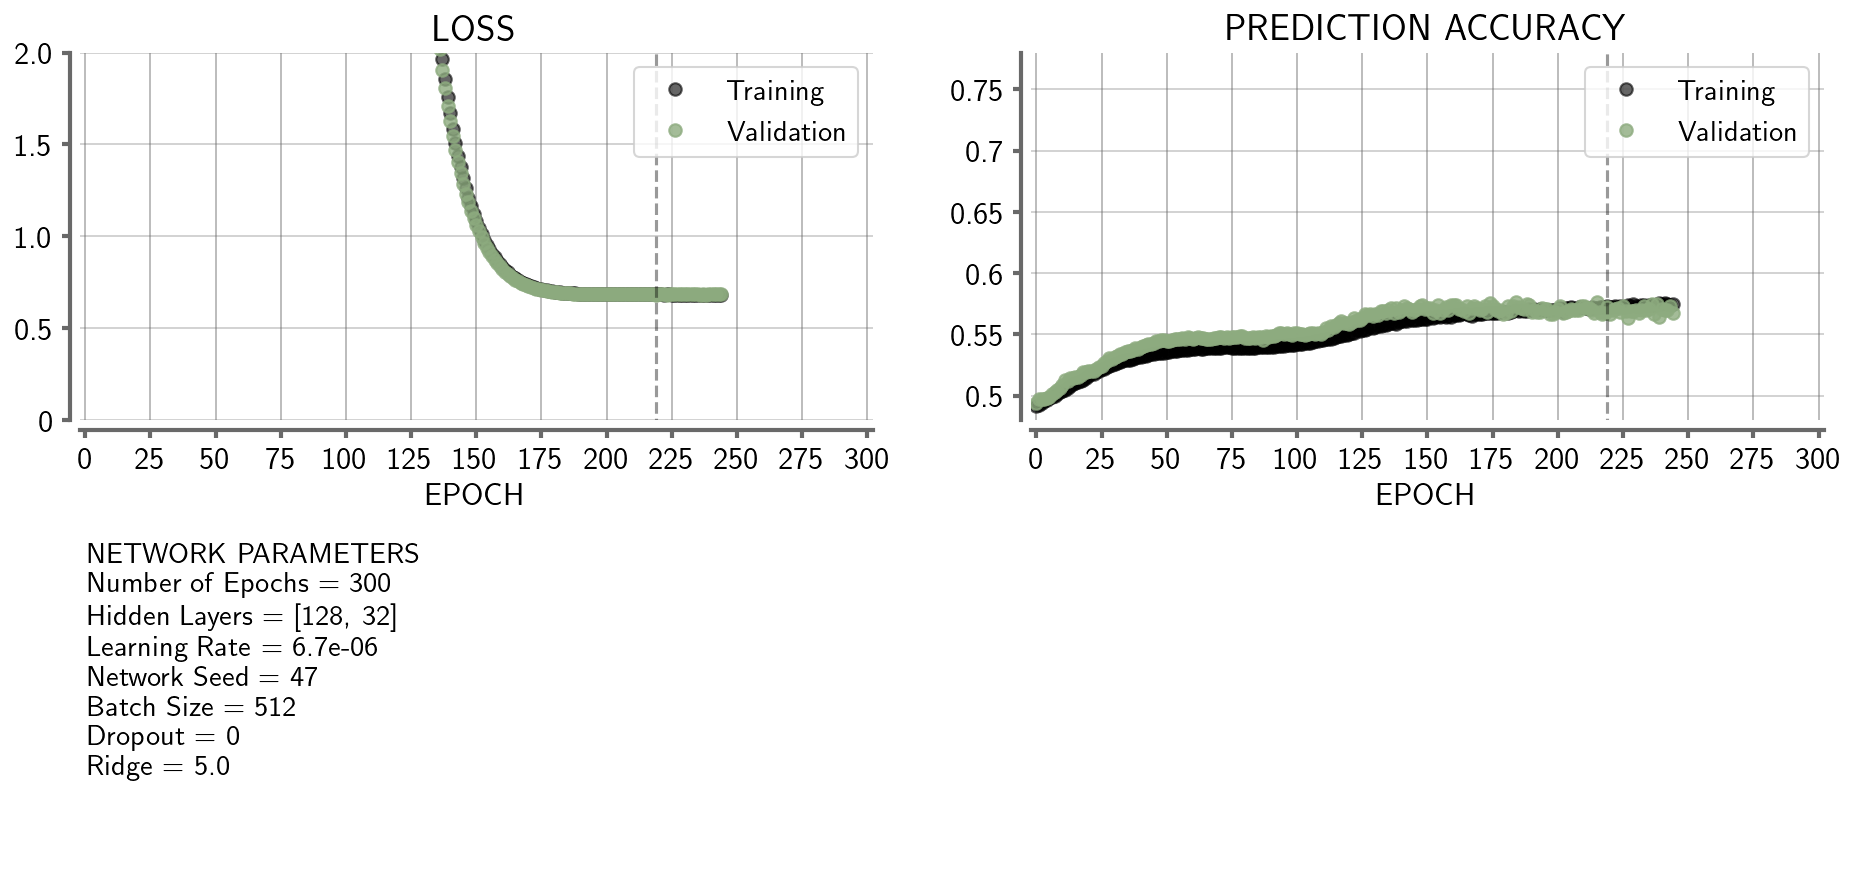

2970/2970 [==============================] - 10s 3ms/step
Zero prediction accuracy: 56%
Zero: 52.% of predictions
One prediction accuracy: 57%
One: 47.% of predictions
Validation Loss at Best Epoch: 0.6824284791946411
33
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3168)]            0         
                                                                 
 dense (Dense)               (None, 128)               405632    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 409,826
Trainable params: 409,826
Non-trainable params: 0
________________________________

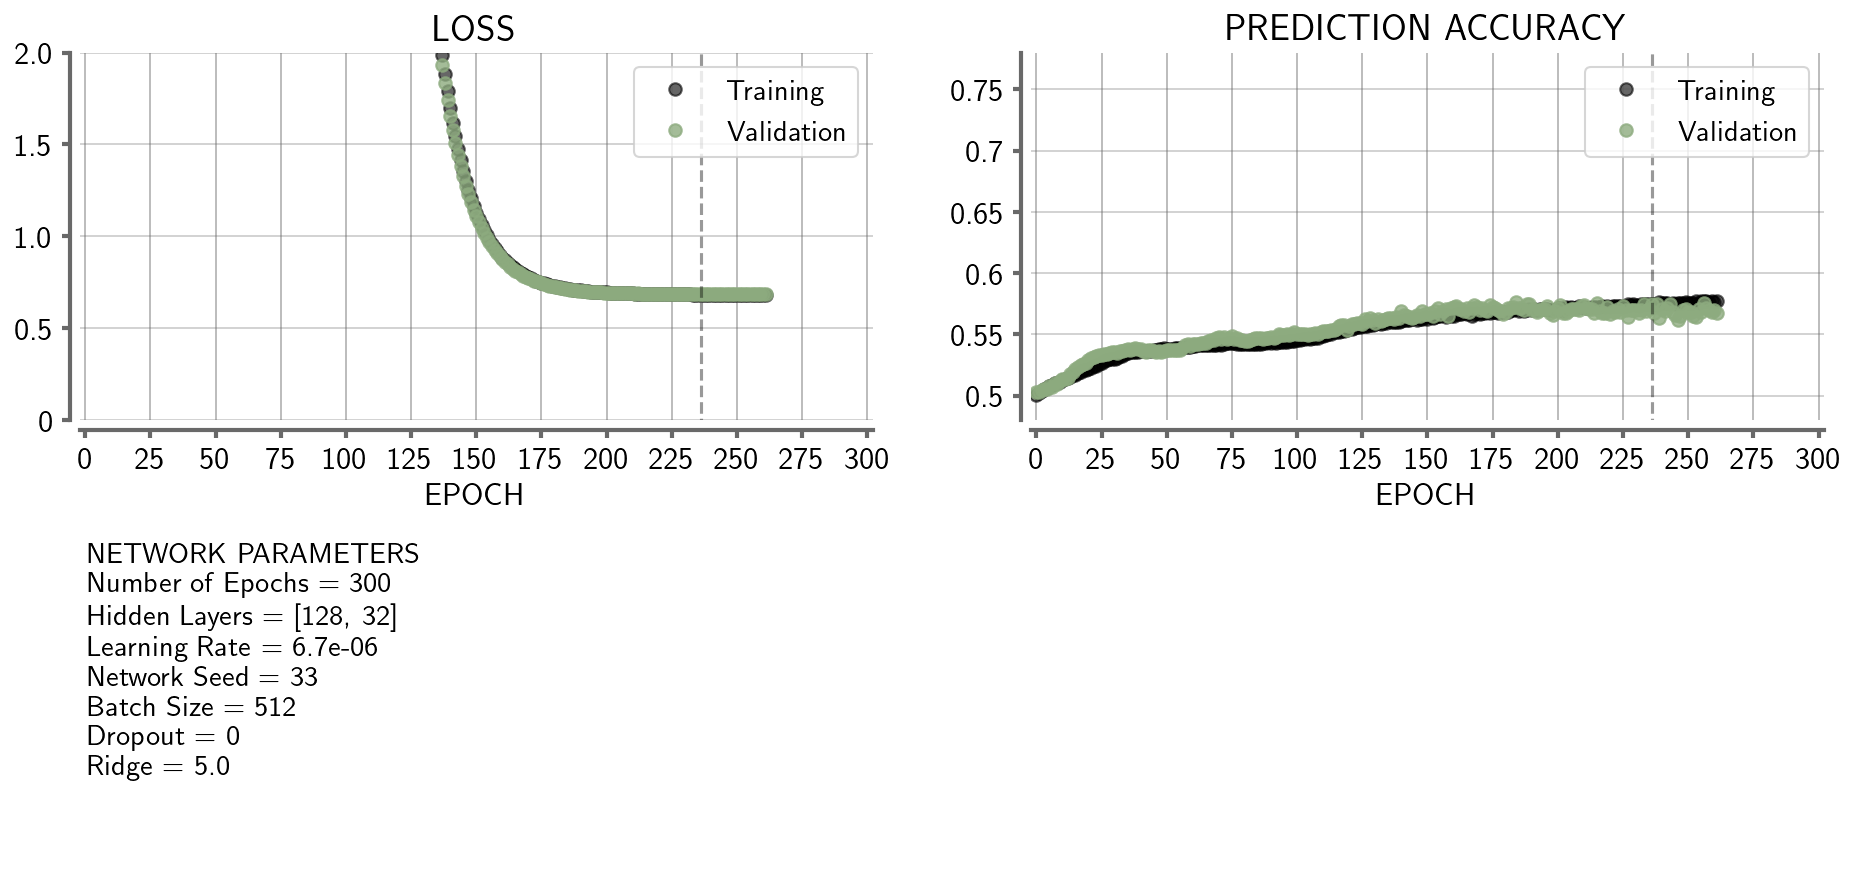

2970/2970 [==============================] - 10s 4ms/step
Zero prediction accuracy: 57%
Zero: 51.% of predictions
One prediction accuracy: 57%
One: 48.% of predictions
Validation Loss at Best Epoch: 0.6830741763114929
133
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3168)]            0         
                                                                 
 dense (Dense)               (None, 128)               405632    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 409,826
Trainable params: 409,826
Non-trainable params: 0
_______________________________

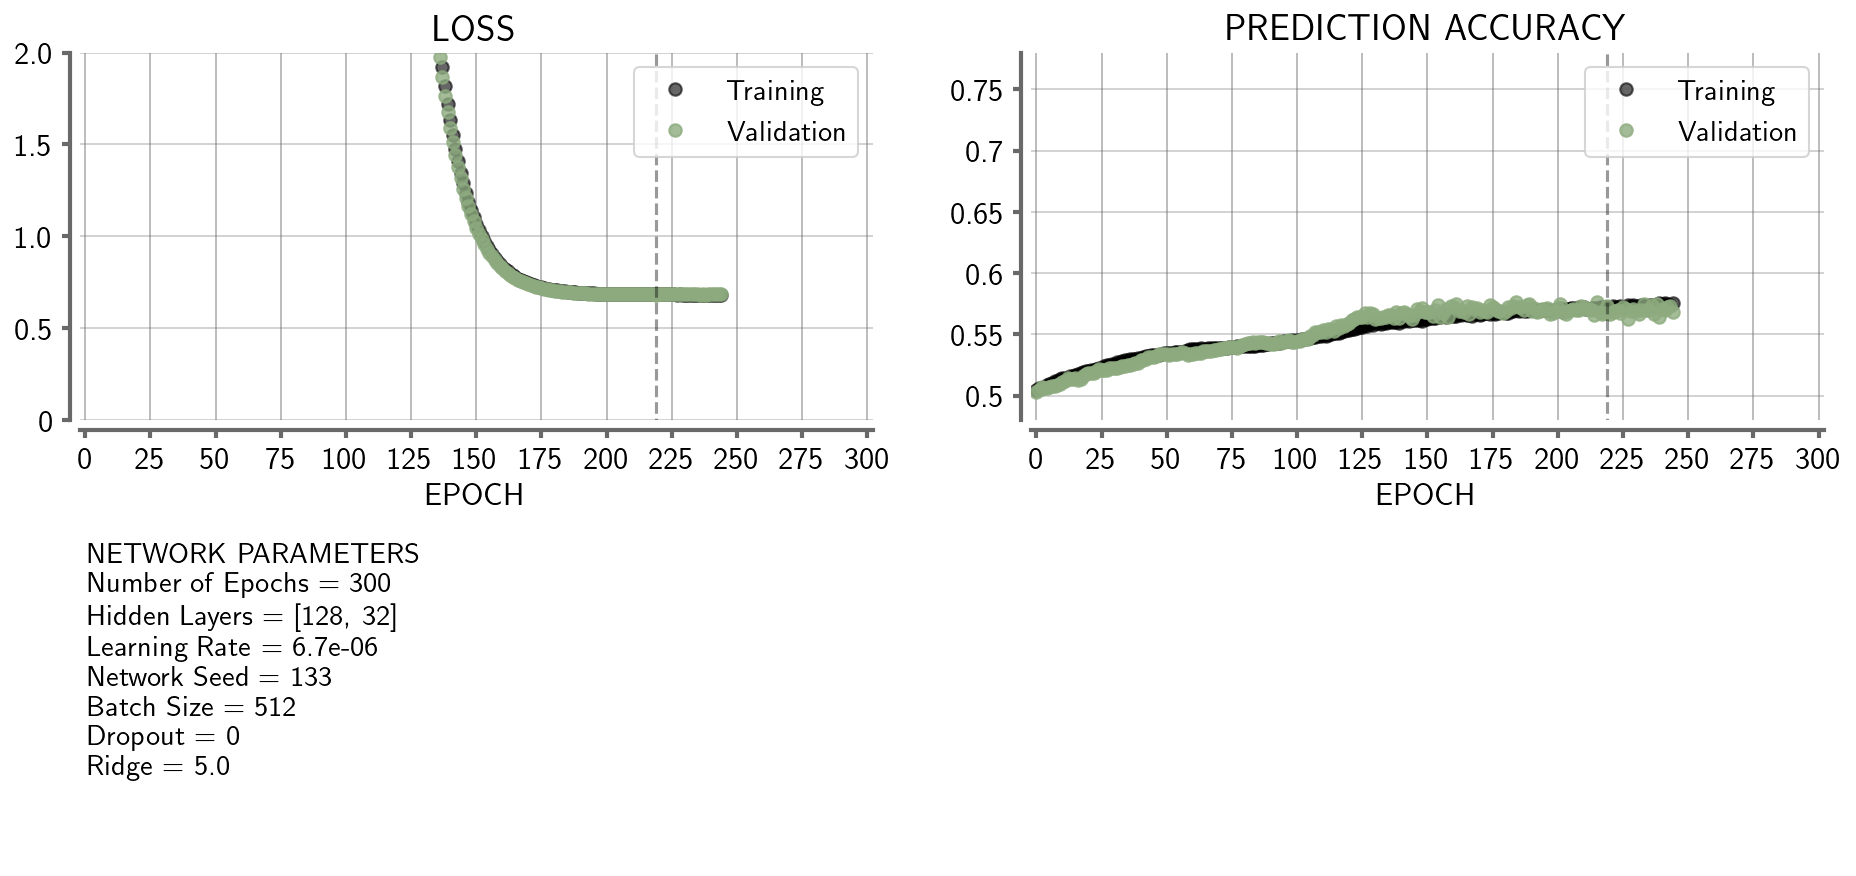

2970/2970 [==============================] - 9s 3ms/step
Zero prediction accuracy: 56%
Zero: 52.% of predictions
One prediction accuracy: 57%
One: 47.% of predictions
Validation Loss at Best Epoch: 0.6824842691421509
410
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3168)]            0         
                                                                 
 dense (Dense)               (None, 128)               405632    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 409,826
Trainable params: 409,826
Non-trainable params: 0
________________________________

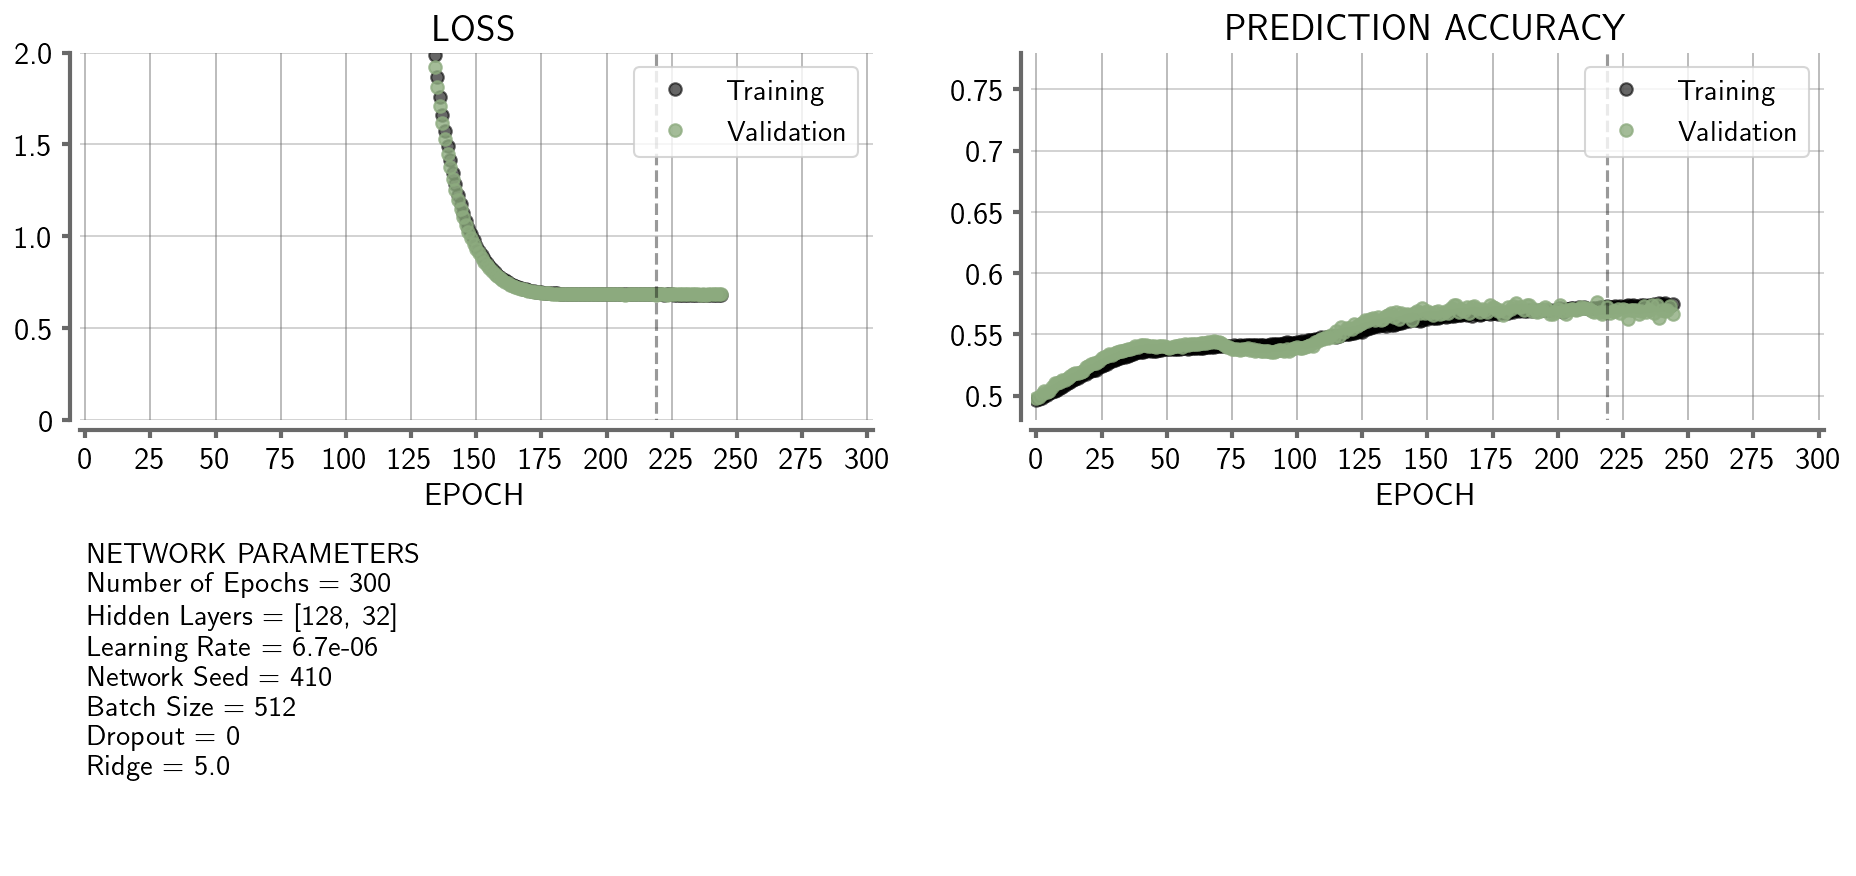

2970/2970 [==============================] - 10s 3ms/step
Zero prediction accuracy: 56%
Zero: 52.% of predictions
One prediction accuracy: 57%
One: 47.% of predictions
Validation Loss at Best Epoch: 0.6823826432228088
692
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3168)]            0         
                                                                 
 dense (Dense)               (None, 128)               405632    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 409,826
Trainable params: 409,826
Non-trainable params: 0
_______________________________

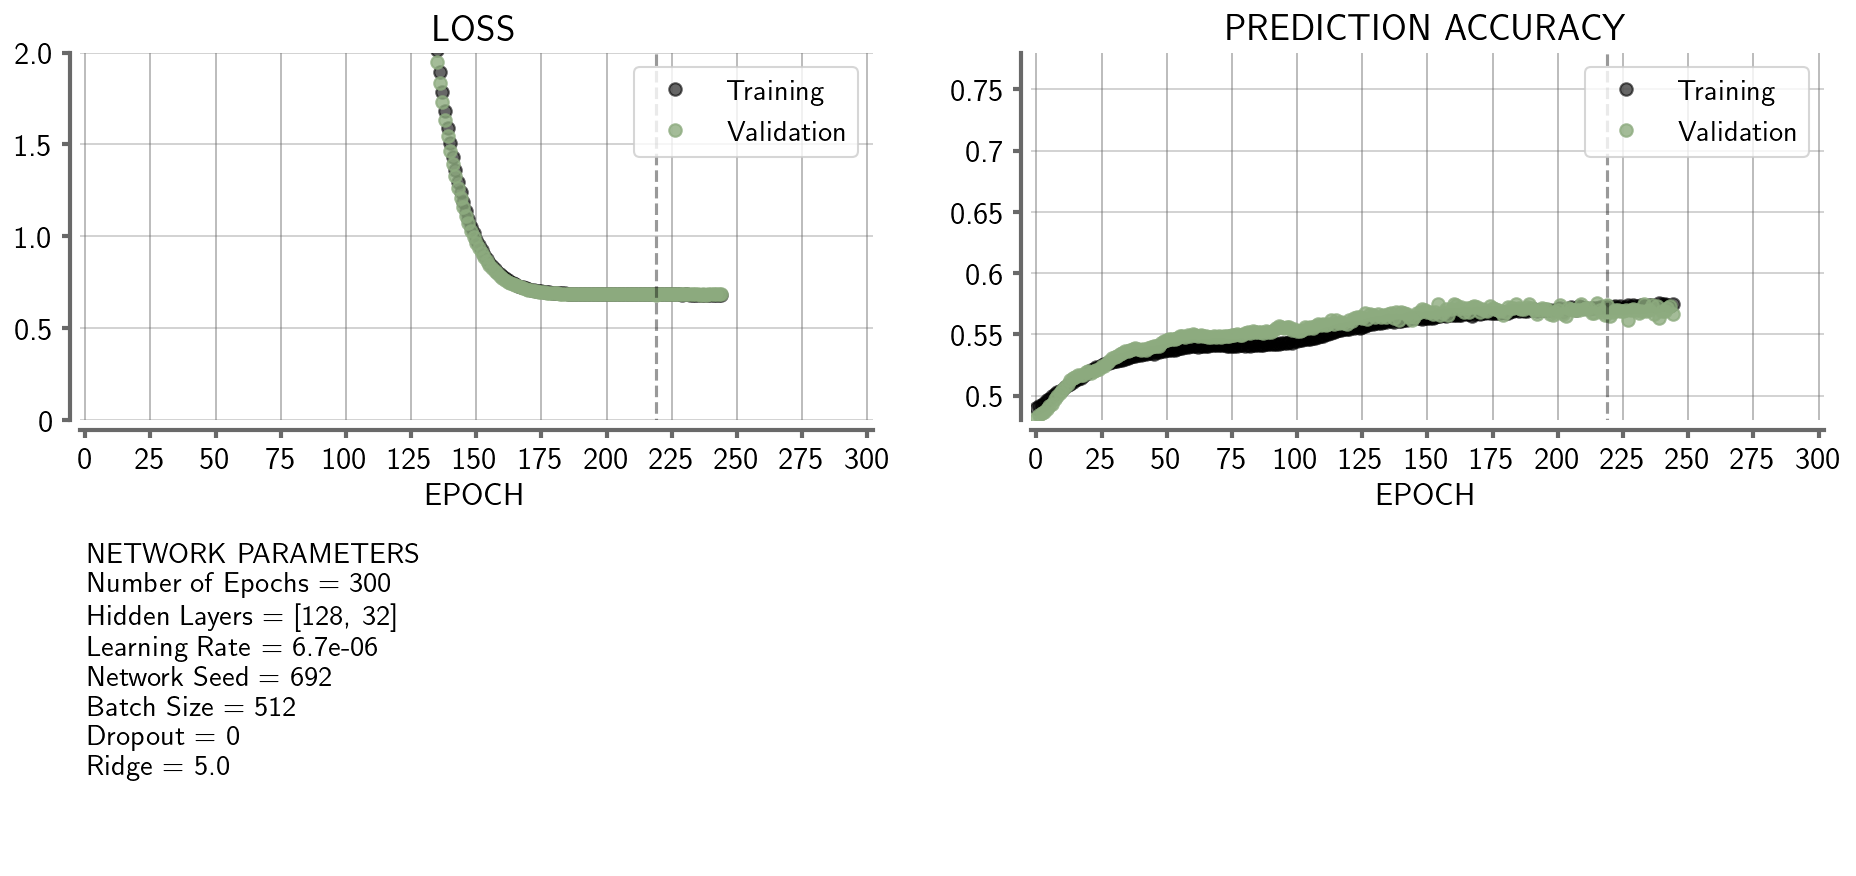

2970/2970 [==============================] - 10s 3ms/step
Zero prediction accuracy: 57%
Zero: 52.% of predictions
One prediction accuracy: 57%
One: 47.% of predictions
Validation Loss at Best Epoch: 0.6822670698165894
64
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3168)]            0         
                                                                 
 dense (Dense)               (None, 128)               405632    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 409,826
Trainable params: 409,826
Non-trainable params: 0
________________________________

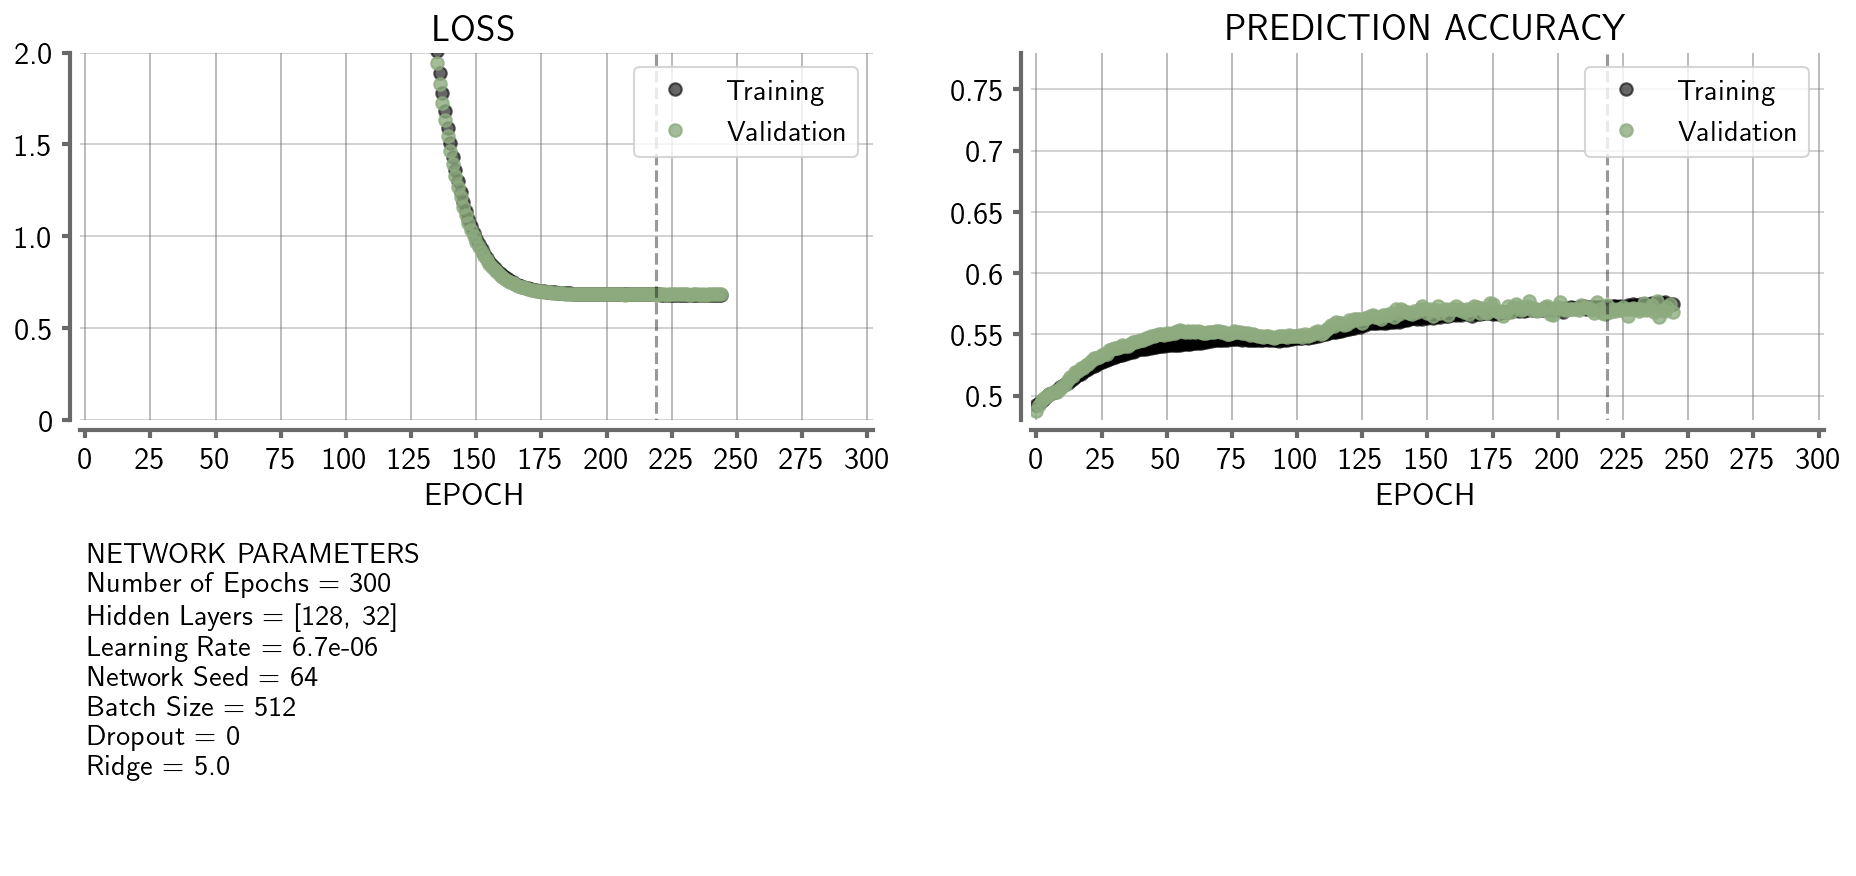

2970/2970 [==============================] - 10s 3ms/step
Zero prediction accuracy: 56%
Zero: 53.% of predictions
One prediction accuracy: 57%
One: 46.% of predictions
Validation Loss at Best Epoch: 0.6822620630264282
99
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3168)]            0         
                                                                 
 dense (Dense)               (None, 128)               405632    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 409,826
Trainable params: 409,826
Non-trainable params: 0
________________________________

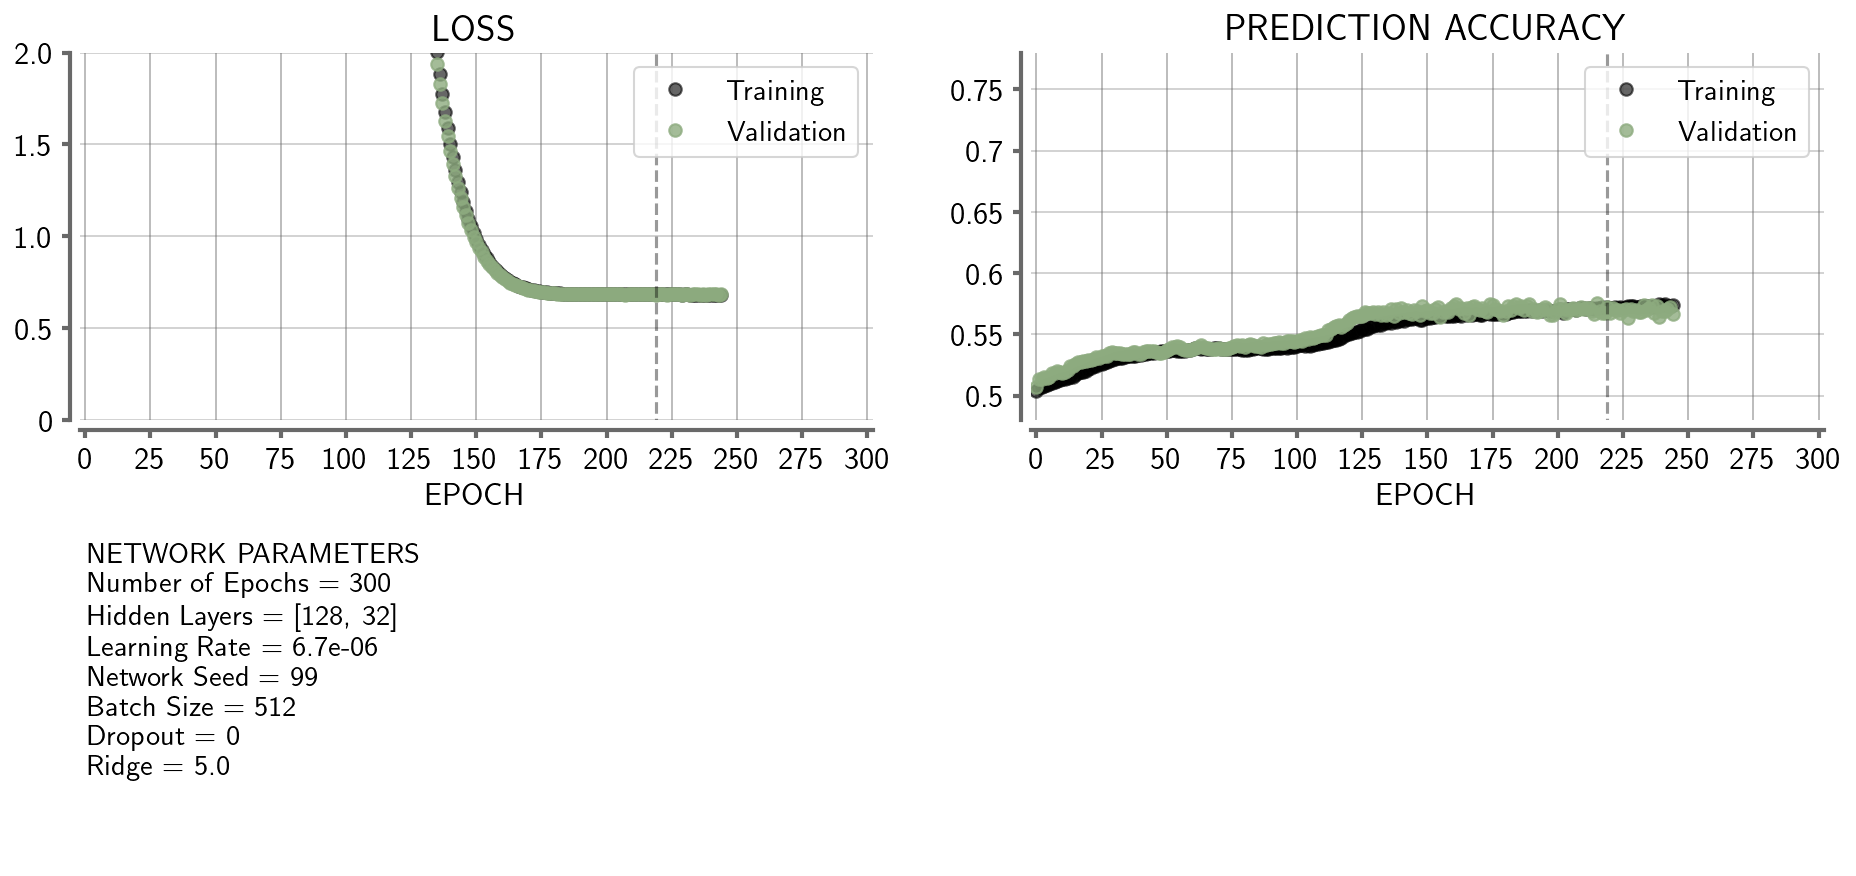

2970/2970 [==============================] - 9s 3ms/step
Zero prediction accuracy: 56%
Zero: 52.% of predictions
One prediction accuracy: 57%
One: 47.% of predictions
Validation Loss at Best Epoch: 0.6822684407234192
910
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3168)]            0         
                                                                 
 dense (Dense)               (None, 128)               405632    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 409,826
Trainable params: 409,826
Non-trainable params: 0
________________________________

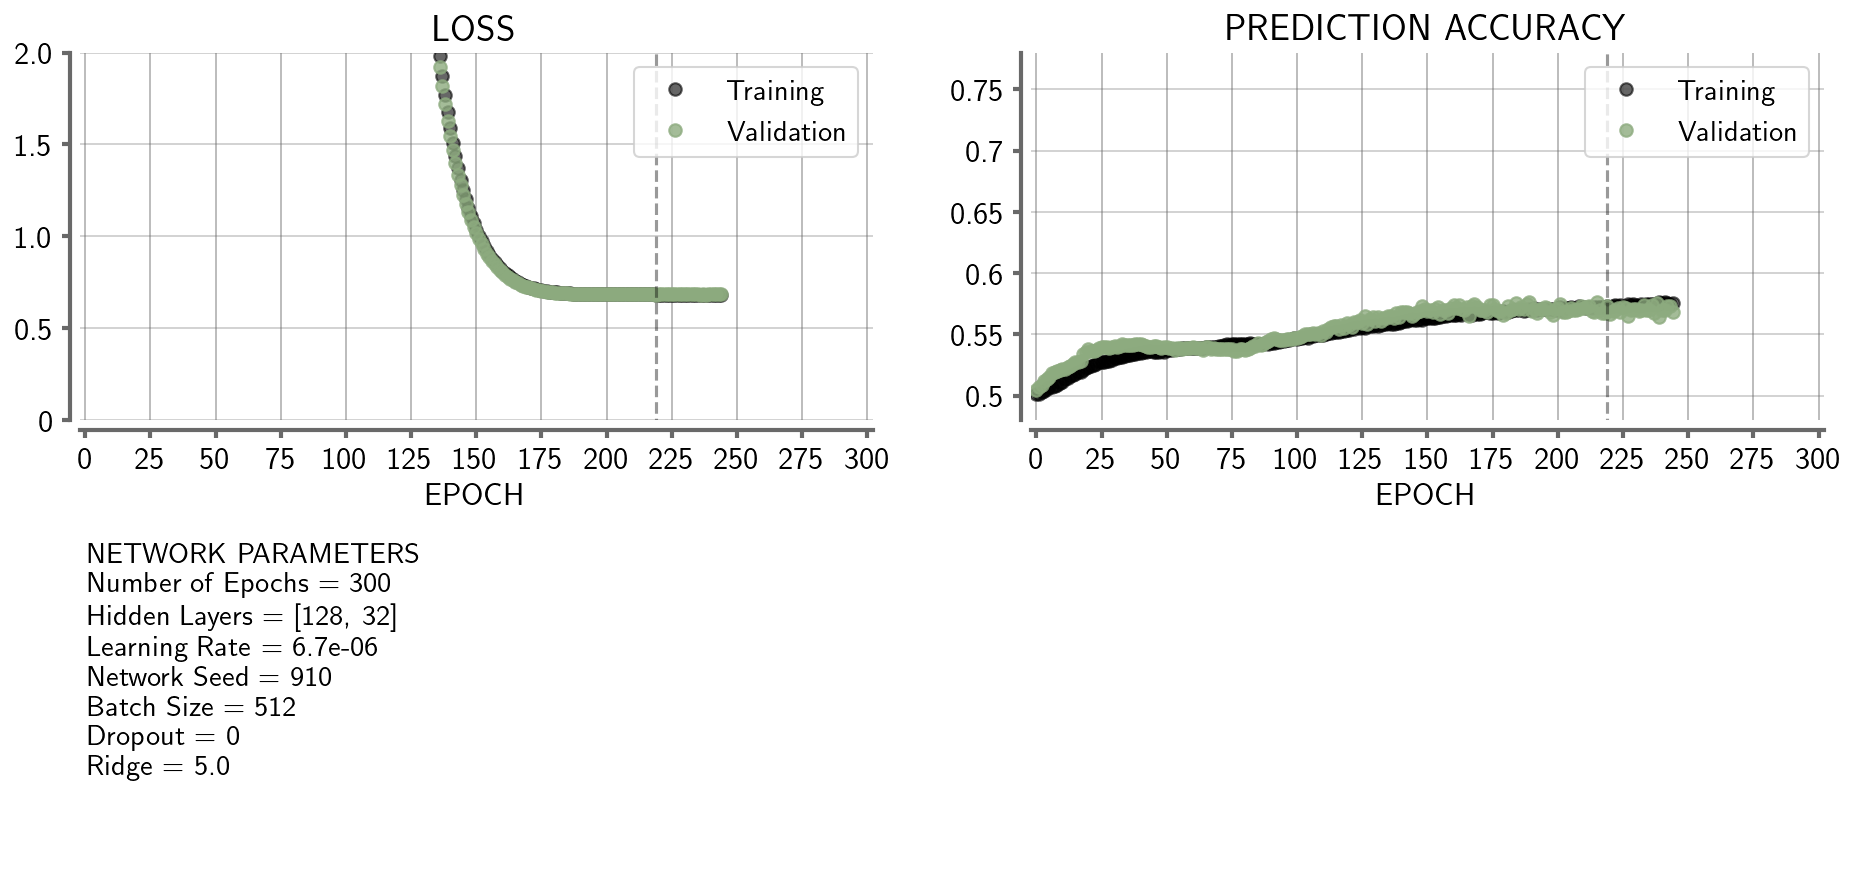

2970/2970 [==============================] - 9s 3ms/step
Zero prediction accuracy: 56%
Zero: 52.% of predictions
One prediction accuracy: 57%
One: 47.% of predictions
Validation Loss at Best Epoch: 0.6822887063026428
92
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3168)]            0         
                                                                 
 dense (Dense)               (None, 128)               405632    
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 409,826
Trainable params: 409,826
Non-trainable params: 0
_________________________________

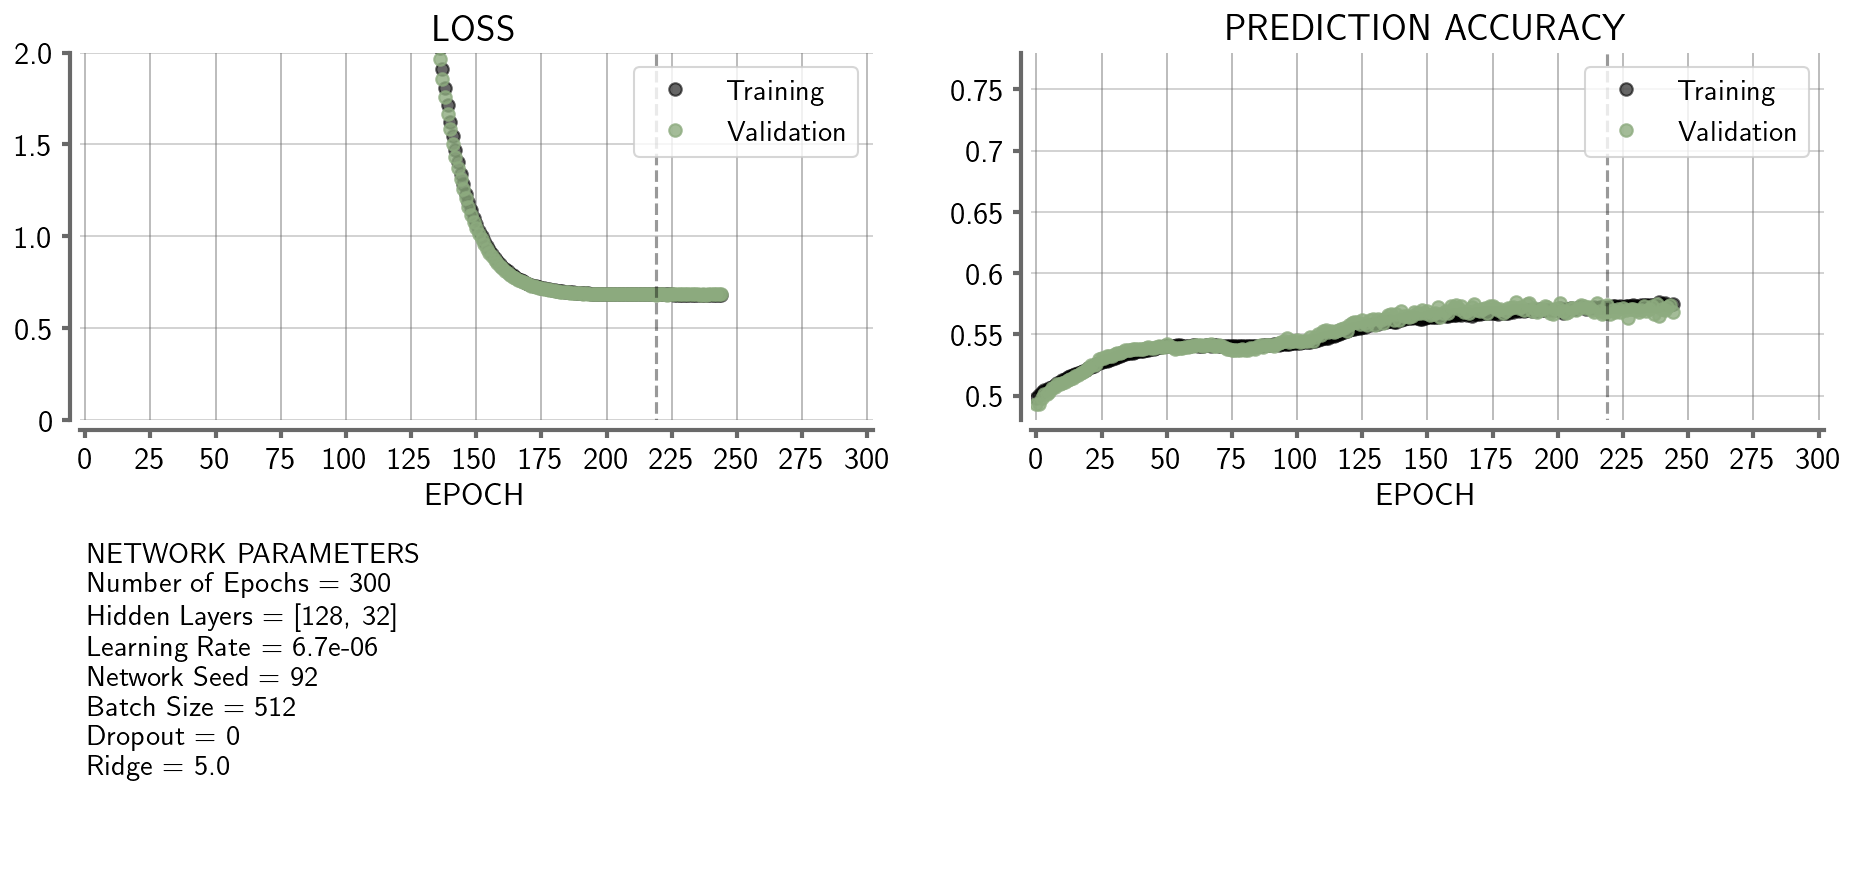

2970/2970 [==============================] - 5s 2ms/step
Zero prediction accuracy: 57%
Zero: 52.% of predictions
One prediction accuracy: 57%
One: 47.% of predictions
Validation Loss at Best Epoch: 0.68222975730896


In [11]:
# -------------------- TRAIN NN --------------------

for NETWORK_SEED in RANDOM_SEED:
    print(NETWORK_SEED)
    # the network seed changes the random seed for the initialized weights.
    # this means that a different network seed can give a different result (e.g. it finds a different minimum in the loss)
    # ----- MAKE NN -----
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',     #monitor='val_prediction_accuracy'
                                                   patience=PATIENCE,
                                                   mode='auto',
                                                   restore_best_weights=True,
                                                   verbose=1)
    #lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=0) #I don't use in this study 
    #callbacks = [es_callback,lr_callback]
    callbacks = [es_callback]
                   
    model, loss_function = make_model()
    
    hotlabels = onehotlabels[:,:model.output_shape[-1]]
    hotlabels_val = onehotlabels_val[:,:model.output_shape[-1]]
    
    # ----- TRAINING NETWORK -----
    start_time = time.time()
    history = model.fit(X_train,
                        hotlabels,
                        validation_data=(X_val, hotlabels_val),
                        batch_size=BATCH_SIZE,
                        epochs=N_EPOCHS,
                        shuffle=True,
                        verbose=0,
                        callbacks=callbacks,
                       )
    stop_time = time.time()
    tf.print(f"Elapsed time during fit = {stop_time - start_time:.2f} seconds\n")
    
    # ----- SAVE MODEL -----
    fi = '_operationalseed'+str(NETWORK_SEED)+'.h5' 
    model.save_weights(ddir_out+fi)
    
    # ----- PLOT THE RESULTS -----
    plot.plot_results(
        history,
        exp_info=(N_EPOCHS, HIDDENS, LR_INIT, BATCH_SIZE, NETWORK_SEED, PATIENCE, RIDGE1, DROPOUT),
        showplot=True
    )
    
    # ----- PRINT THE RESULTS -----
    predictions = np.argmax(model.predict(X_val),axis=-1)
    predictions_training = np.argmax(model.predict(X_train),axis=-1)
    confusion_training = tf.math.confusion_matrix(labels=Ytrain, predictions=predictions_training)
    confusion = tf.math.confusion_matrix(labels=Yval, predictions=predictions)
    zero_precision  = (np.sum(confusion[0,0])/np.sum(confusion[:,0])) * 100
    one_precision   = (np.sum(confusion[1,1])/np.sum(confusion[:,1])) * 100
        
    # Number of times network predicts a given class
    zero_predictions  = (np.shape(np.where(predictions==0))[1]/predictions.shape[0])* 100
    one_predictions   = (np.shape(np.where(predictions==1))[1]/predictions.shape[0])* 100
    
    print('Zero prediction accuracy: '+str(zero_precision)[:2]+'%')
    print('Zero: '+str(zero_predictions)[:3]+'% of predictions')
    print('One prediction accuracy: '+str(one_precision)[:2]+'%')
    print('One: '+str(one_predictions)[:3]+'% of predictions')
    
    print('Validation Loss at Best Epoch: '+str(es_callback.best*1))#+'%')

    # ----- END LOOP -----

In [12]:
def confusion_matrix(predclasses, targclasses):

    class_names = np.unique(targclasses)

    table = []
    for pred_class in class_names:
        row = []
        for true_class in class_names:
            row.append(100 * np.mean(predclasses[targclasses == true_class] == pred_class))
        table.append(row)
    class_titles_t = ["T(Pos)", "T(Neg)"]
    class_titles_p = ["P(Pos)", "P(Neg)"]
    conf_matrix = pd.DataFrame(table, index=class_titles_p, columns=class_titles_t)
    display(conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f}"))

In [13]:
# What predictions did the model make for our training, validation, and test sets?
Ptrain = model.predict(X_train) # Array of class likelihoods for each class
Pval = model.predict(X_val)

Cptrain = Ptrain.argmax(axis=1) # 1-D array of predicted class (highest likelihood)
Cpval = Pval.argmax(axis=1)     #argmax along axis=1 returns the index which has the highest value for each row 

Cttrain = hotlabels.argmax(axis=1) # 1-D array of truth class
Ctval = hotlabels_val.argmax(axis=1)

367/367 [==============================] - 1s 2ms/step


In [14]:
print("Predicted versus Target Classes")
print("")
print("Training")
confusion_matrix(Cptrain, Cttrain)
print("Validation")
confusion_matrix(Cpval, Ctval)

Predicted versus Target Classes

Training


,T(Pos),T(Neg)
P(Pos),60.0,44.3
P(Neg),40.0,55.7


Validation


,T(Pos),T(Neg)
P(Pos),60.1,45.3
P(Neg),39.9,54.7


367/367 [==============================] - 1s 1ms/step


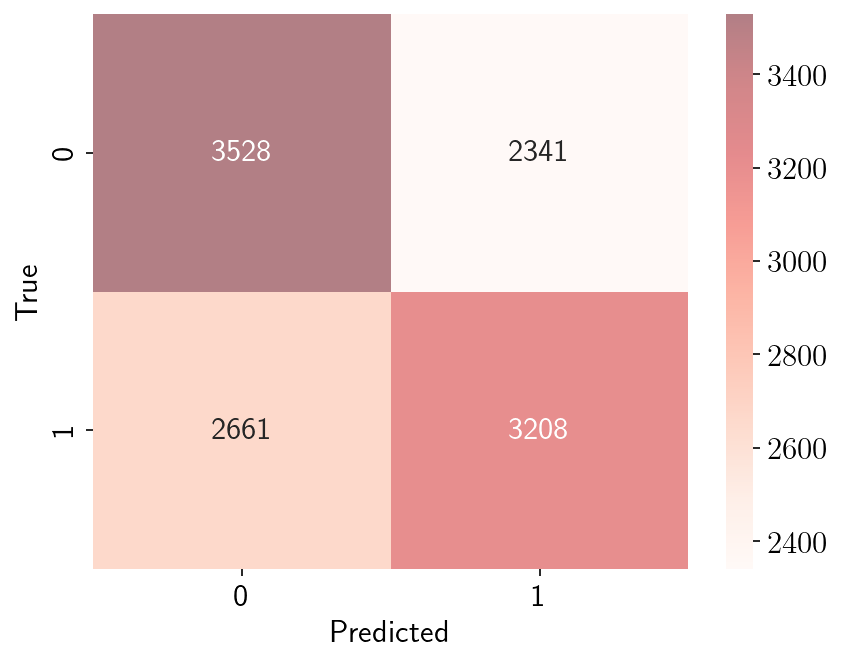

In [15]:
predictions = np.argmax(model.predict(X_val),axis=-1)
confusion = tf.math.confusion_matrix(labels=Yval, predictions=predictions)
sns.heatmap(confusion,annot=True,cmap=plt.cm.Reds, alpha=0.5, fmt ='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig(ddir_out+'confusion_matrix_lastseed.png', format='png')